# 1 Setting

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications.xception import Xception

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/CORE/Colaboratory')

In [ ]:
trainp = '/content/drive/MyDrive/Colab Notebooks/CORE/Colaboratory/CNN_train/'
testp = '/content/drive/MyDrive/Colab Notebooks/CORE/Colaboratory/CNN_test/'

# os.listdir(trainp)
# os.listdir(testp)

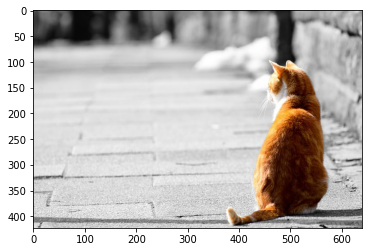

In [ ]:
# 이미지 하나 불러와서 확인

a = Image.open(trainp + 'cat/cat_1.jpg')    
plt.imshow(a)

# 2 Data preprocessing + augmentation

In [ ]:
# set batchsize(bs) and image size(isize)
bs = 50
isize = (256,256)

# set generator(gen) to bring and preprocess images together
train_gen = ImageDataGenerator(rescale = 1/255, validation_split = 0.1,
                         #width_shift_range = 0.1,
                         #height_shift_range = 0.1,
                         #rotation_range = 5,
                         shear_range = 0.2,
                         zoom_range = 0.2,
                         horizontal_flip = True
                         ) 
test_gen = ImageDataGenerator(rescale = 1/255, validation_split = 0.1)

# load train, validation, and test data
traind = train_gen.flow_from_directory(trainp, 
                                       target_size = isize, 
                                       batch_size = bs, 
                                       class_mode = 'categorical', 
                                       subset='training'
                                       )
vald = test_gen.flow_from_directory(trainp, 
                                    target_size = isize,
                                    batch_size = bs, 
                                    class_mode = 'categorical', 
                                    subset='validation'
                                    )
testd = test_gen.flow_from_directory(testp, 
                                     target_size = isize, 
                                     batch_size = bs, 
                                     class_mode = 'categorical'
                                     )

Found 2520 images belonging to 4 classes.
Found 280 images belonging to 4 classes.
Found 729 images belonging to 1 classes.


# 3 CNN model with transfer learning

4 class 분류문제. 

활성화함수는 softmax. loss함수는 categorical_crossentropy.

모델의 파라미터 개수보다 적은 수의 데이터 샘플을 이용하는 경우 과적합이 쉽게 발생.

1. Dropout을 적용하는 순서는 대체로 ReLU등의 Activation 함수 적용 이후, Pooling 이전일때가 가장 적절하다고 한다. [Convolution - Batch Normalization - Activation - Dropout - Pooling]

배치 정규화와 드랍아웃 저자들의 의견 정리
1. 배치 정규화의 경우 convolution layer 또는 fully connected layer 등의 layer 뒤에 적용되는 것이 맞다고 봄.
2. ReLU와 같은 Activation function을 적용하기 전에 적용하는 것을 추천.
3. 왜냐하면 배치 정규화의 목적이 네트워크 연산 결과가 원하는 방향의 분포대로 나오는 것이기 때문에 핵심 연산인 convolution 연산 뒤에 바로 적용하여 정규화하는 것이 핵심.

In [ ]:
model = Xception(input_shape=[256,256,3], weights='imagenet', include_top=False)

for layer in model.layers:
    layer.trainable = False

# model.summary()

In [ ]:
# epoch 100 & train data 2520

In [ ]:
md = Sequential()

md.add(model)

md.add(Conv2D(32,(3,3), activation='relu'))
md.add(BatchNormalization())
#md.add(MaxPooling2D())
#md.add(Dropout(0.3))

md.add(Conv2D(64,(3,3), activation='relu'))
md.add(BatchNormalization())
md.add(MaxPooling2D())
#md.add(Dropout(0.3))

########################################################

md.add(Flatten())
md.add(Dense(64, activation='relu'))
md.add(Dropout(0.4))
md.add(Dense(16, activation='relu'))
md.add(Dropout(0.3))
md.add(Dense(4, activation='softmax'))

# md.summary()

# 4 CNN model compile & fit with early stopping

In [ ]:
# earlystopping에서 patience 사용 시 최적의 모델을 사용할 수 없다는 한계가 있음.
# 따라서 modelcheckpoint를 사용해 최적 모델 저장할 수 있도록 함.

es = [EarlyStopping(monitor='val_acc', patience = 7), ModelCheckpoint(filepath = 'best_model.h5', monitor = 'val_acc', save_best_only = True)]

md.compile(optimizer = 'RMSProp', loss = 'categorical_crossentropy', metrics = 'acc')

hist = md.fit(traind, epochs = 50, validation_data = vald, callbacks = es)

md = load_model('best_model.h5')

# 5 Visualization of accuracy & loss

In [ ]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

acc = hist.history['acc']
val_acc = hist.history['val_acc']

ep = np.arange(1,len(loss)+1)

In [ ]:
plt.figure()

plt.plot(ep, loss, 'b', label = 'loss')
plt.plot(ep, val_loss, 'g', label = 'val_loss')
plt.title('Loss')
plt.legend()

In [ ]:
plt.figure(figsize=(10,8))

plt.plot(ep, acc, 'r', label = 'acc')
plt.plot(ep, val_acc, 'y', label = 'val_acc')
plt.title('Accuracy')
plt.legend()

# 6 test data에 대한 모델 성능 확인

In [ ]:
# TrainI=ImageDataGenerator(rescale=1/255, validation_split=0.1)
# TestI=ImageDataGenerator(rescale=1/255)
sub = pd.read_csv('../input/animal-classification/Sample_submission.csv')

testdf = sub.copy()
testdf['ID'] = testdf['ID'].astype('str')
testdf['file'] = testp+'test/'+testdf['ID']+'.jpg'

testd = test_gen.flow_from_dataframe(testdf, x_col = 'file', y_col=None, target_size = isize, class_mode = None, shuffle = False)

In [ ]:
results = md.predict(testd)

results

In [ ]:
results =results.argmax(1)

df = pd.DataFrame(results)
df
df.to_csv('sub.csv', index=False)